# Facial Feature Detection with OpenFace

This notebook uses an open source project [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace) by Tadas Baltrusaitis to detect and track multi-person head motions and facial muscle movements on a given Youtube video. This notebook was inspired by [DL-CoLab-Notebooks](https://github.com/tugstugi/dl-colab-notebooks).

## Install OpenFace
The first code snippet installs all the necessary dependencies and may take a while (30~40 minutes). Go make yourself a cup of coffee and watch some Youtube videos to find the clips you'd like to extract facial features from while your environment sets up.


In [1]:
import os
from os.path import exists, join, basename, splitext

################# Need to revert back to CUDA 10.0 ##################
# Thanks to http://aconcaguasci.blogspot.com/2019/12/setting-up-cuda-100-for-mxnet-on-google.html
#Uninstall the current CUDA version
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

#Download CUDA 10.0
!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#install CUDA kit dpkg
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0
#Slove libcurand.so.10 error
!wget --no-clobber http://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
#-nc, --no-clobber: skip downloads that would download to existing files.
!apt install ./nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb
!apt-get update
####################################################################

git_repo_url = 'https://github.com/TadasBaltrusaitis/OpenFace.git'
project_name = splitext(basename(git_repo_url))[0]
# clone openface
!git clone -q --depth 1 $git_repo_url

# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
!tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# Get newest GCC
!sudo apt-get update
!sudo apt-get install build-essential 
!sudo apt-get install g++-8

#added 5/15/2022. Thanks to @weskhoo
!sudo apt-key del 7fa2af80
!sudo apt-key adv --fetch-keys http://developer.download.nvidia.com/compute/cuda/repos/ubuntu1604/x86_64/3bf863cc.pub

# install python dependencies
!pip install -q youtube-dl

# Finally, actually install OpenFace
!cd OpenFace && bash ./download_models.sh && sudo bash ./install.sh

/bin/bash: apt-get: command not found
/bin/bash: dpkg: command not found
/bin/bash: apt-get: command not found
Unable to locate an executable at "/Users/mac/Library/Java/JavaVirtualMachines/openjdk-16.0.1/Contents/Home/bin/apt" (-1)
/bin/bash: apt-get: command not found
文件 “cuda-repo-ubuntu1804_10.0.130-1_amd64.deb” 已经存在；不获取。

/bin/bash: dpkg: command not found
Password:
sudo: a password is required
/bin/bash: apt-get: command not found
/bin/bash: apt-get: command not found
文件 “nvidia-machine-learning-repo-ubuntu1804_1.0.0-1_amd64.deb” 已经存在；不获取。

Unable to locate an executable at "/Users/mac/Library/Java/JavaVirtualMachines/openjdk-16.0.1/Contents/Home/bin/apt" (-1)
/bin/bash: apt-get: command not found


## Detect facial expressions on a test video

We are going to detect facial features on the following Youtube video:

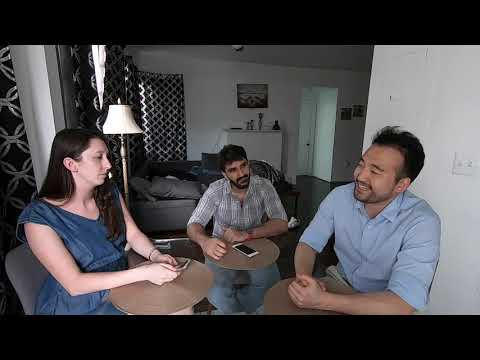

In [1]:
from IPython.display import YouTubeVideo

# Change the Youtube_ID with the link to your group's video.
YOUTUBE_ID = 'XtA6FQz8BHQ'

YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut the first 10 seconds and do the face detection & feature extraction on that clip. This takes about a minute or two. Instead of `FaceLandmarkVidMulti` you may also use `FeatureExtraction` to extract features of a single face or `FaceLandmarkImg` to extract features on a face image. See full description of the arguments [here](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Command-line-arguments). 

In [2]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the first 5 seconds
!ffmpeg -y -loglevel info -i youtube.mp4 -t 10 video.mp4
# clear any previous outputs.
!rm -rf processed
# detect poses on the these 10 seconds.
!./OpenFace/build/bin/FaceLandmarkVidMulti -f video.mp4 -out_dir processed
# convert the result into MP4
!ffmpeg -y -loglevel info -i processed/video.avi output.mp4

/bin/bash: youtube-dl: command not found
/bin/bash: ffmpeg: command not found
/bin/bash: ./OpenFace/build/bin/FaceLandmarkVidMulti: No such file or directory
/bin/bash: ffmpeg: command not found


Finally, visualize the result:

In [1]:
def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('/Users/mac/Desktop/implementation_depression/AV2014_Training_data_NYU/Training/Freeform/203_1_Freeform_video.mp4', width=960, height=720)

# Extra: Here are some tips for loading and plotting the data. 

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd, seaborn as sns
sns.set_style('white')
import matplotlib.pyplot as plt 

# Load data
df = pd.read_csv('processed/video.csv')
# Remove empty spaces in column names.
df.columns = [col.replace(" ", "") for col in df.columns]
# Print few values of data.
print(f"Max number of frames {df.frame.max()}", f"\nTotal shape of dataframe {df.shape}")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'processed/video.csv'

In [ ]:
# See how many unique faces there are
print("Number of unique faces: ", len(df.face_id.unique()), "\nList of face_id's: ", df.face_id.unique())

Number of unique faces:  4 
List of face_id's:  [0 1 2 3]


It looks like we see 4 faces instead of 3! Let's see how much confidence the algorithm had for detecting each face. 


In [ ]:
df.groupby('face_id').mean()['confidence']

face_id
0    0.955367
1    0.888863
2    0.849410
3    0.154000
Name: confidence, dtype: float64

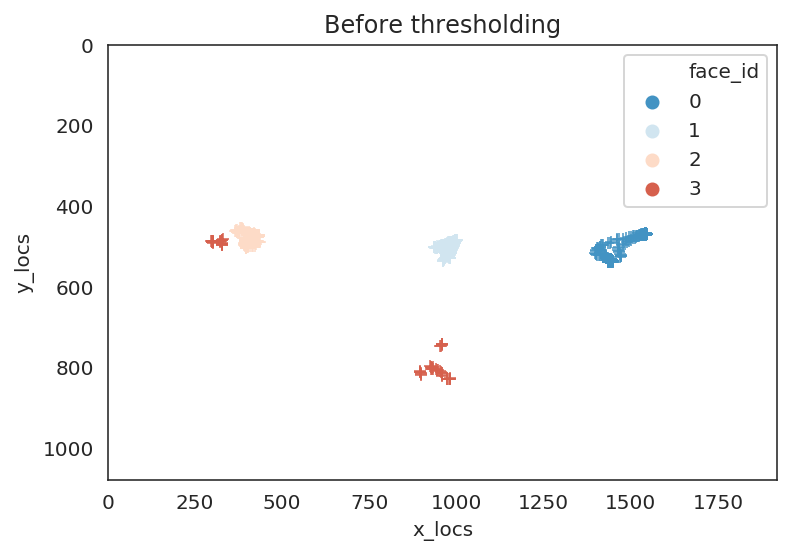

In [ ]:
import re
x_regex_pat = re.compile(r'^x_[0-9]+$')
y_regex_pat = re.compile(r'^y_[0-9]+$')
x_locs = df.columns[df.columns.str.contains(x_regex_pat)]
y_locs = df.columns[df.columns.str.contains(y_regex_pat)]
no_unique_faces = len(df.face_id.unique())
palette = sns.color_palette("RdBu_r", no_unique_faces)

avg_face_df = pd.DataFrame({'x_locs':df[x_locs].mean(axis=1), 'y_locs':df[y_locs].mean(axis=1), 'face_id': df.face_id})
ax = sns.scatterplot(x='x_locs', y='y_locs', hue = 'face_id', data=avg_face_df, marker="+", palette=palette)
ax.set(xlim=[0, 1920], ylim=[1080,0], title="Before thresholding");

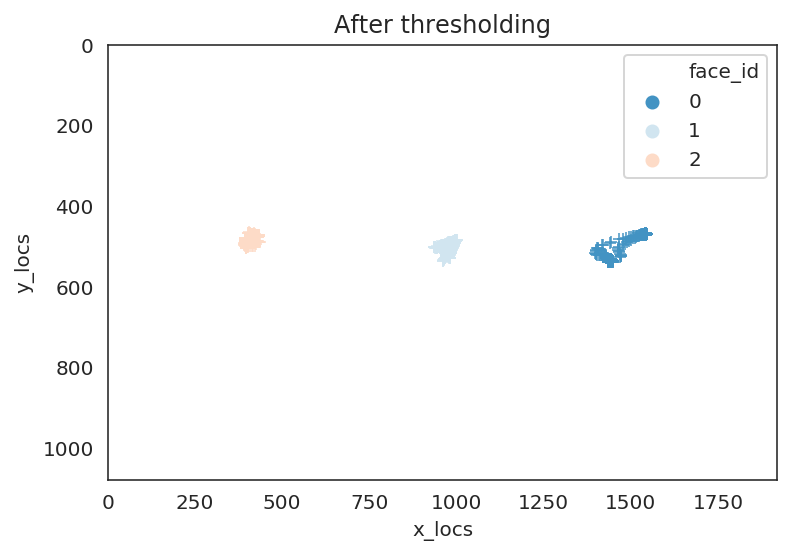

In [ ]:
avg_face_df_conf = avg_face_df[df.confidence>=.80]
no_unique_faces = len(avg_face_df_conf.face_id.unique())
ax = sns.scatterplot(x='x_locs', y='y_locs', hue = 'face_id', data=avg_face_df_conf, marker="+", palette=palette[:no_unique_faces])
ax.set(xlim=[0, 1920], ylim=[1080,0], title="After thresholding");

Let's clean our data with a threshold of 80% confidence and plot the AU trajectories for all AUs.


List of AU columns: Index(['AU01_r', 'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r',
       'AU10_r', 'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r',
       'AU25_r', 'AU26_r', 'AU45_r'],
      dtype='object')


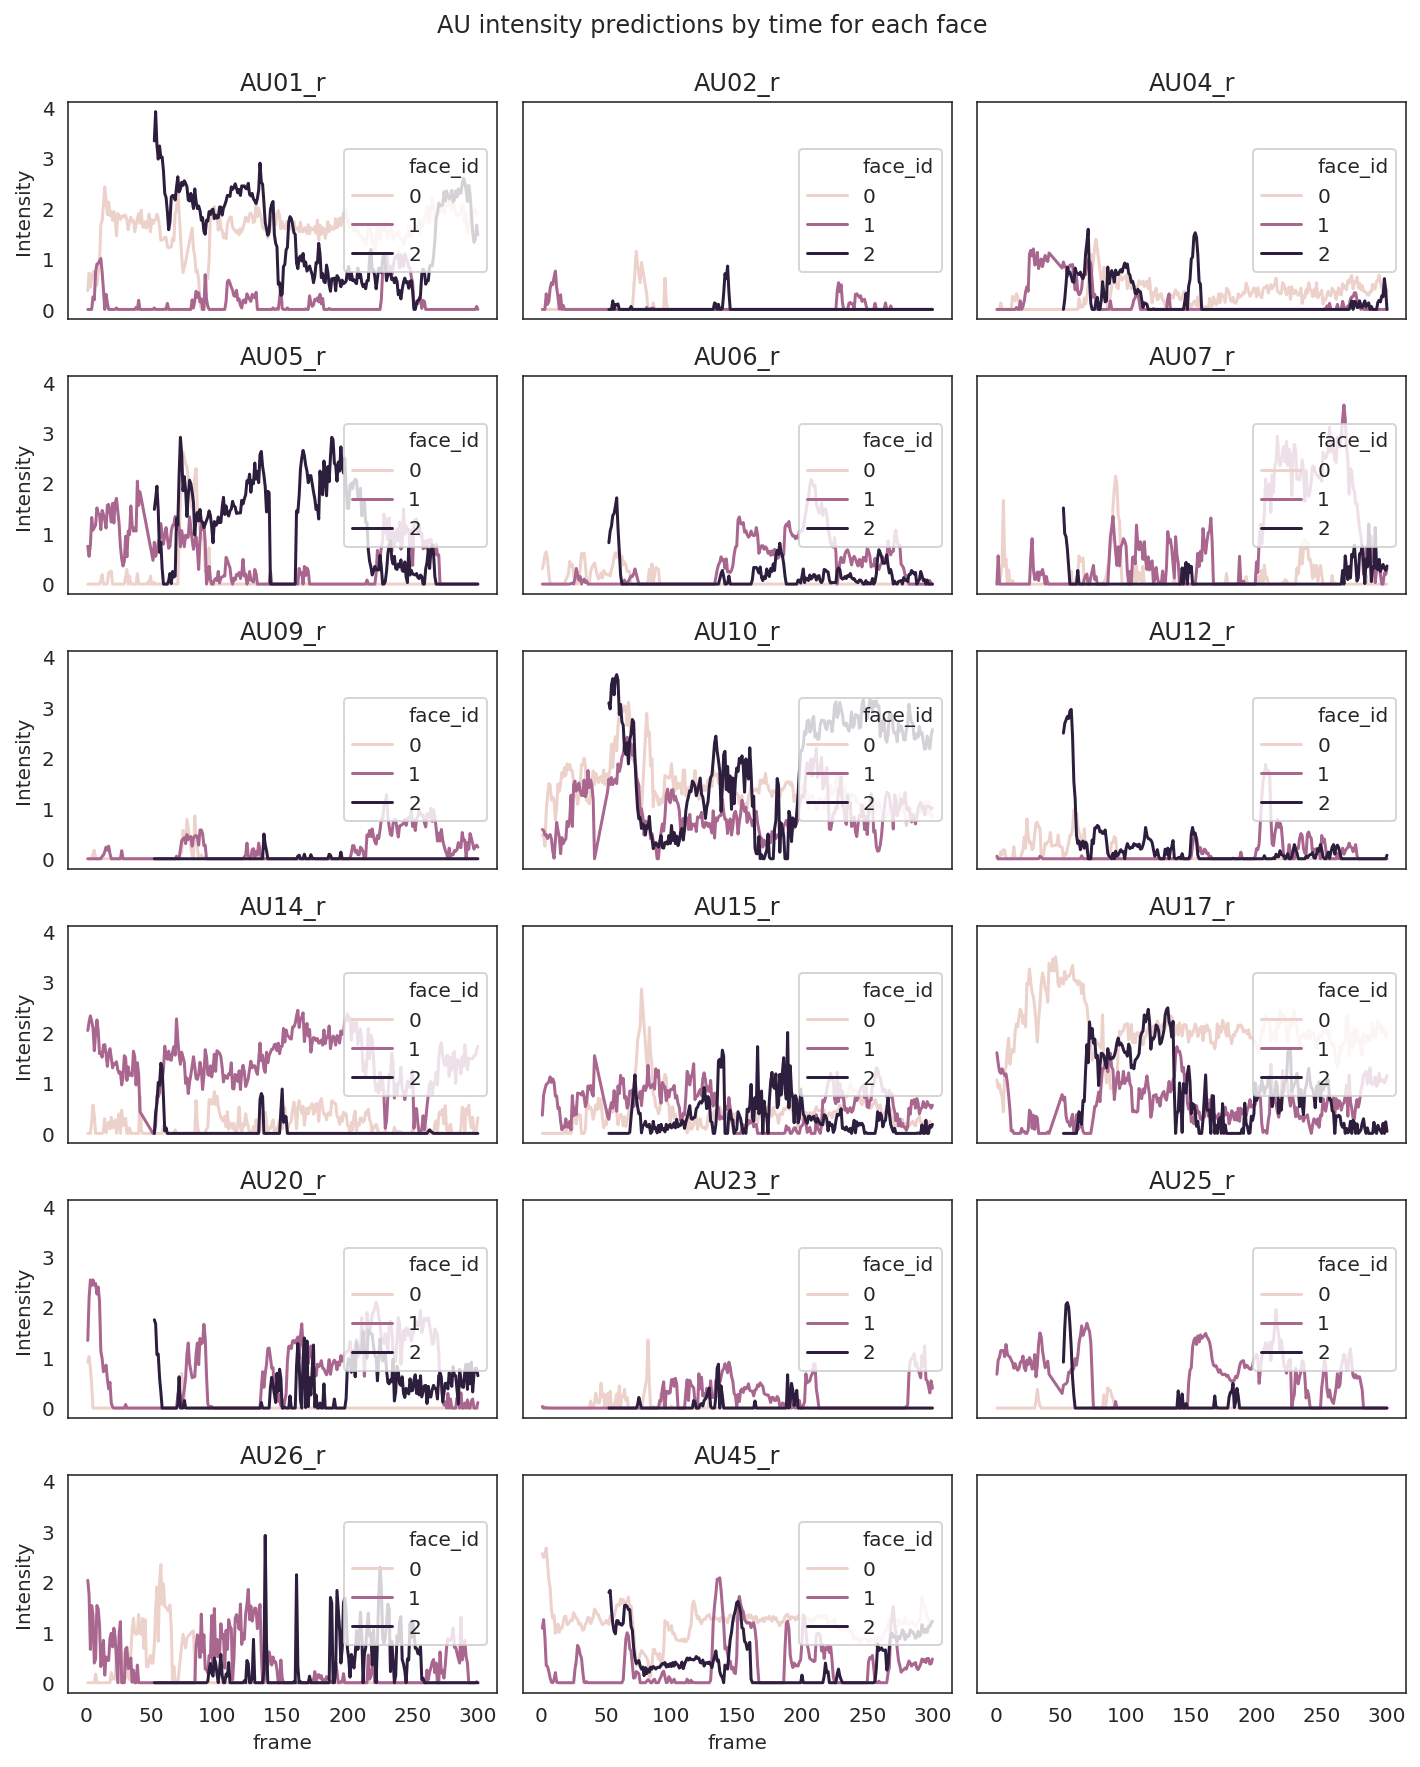

In [ ]:
# Threshold data by 80%
df_clean = df[df.confidence>=.80]
# Plot all Action Unit time series. 
au_regex_pat = re.compile(r'^AU[0-9]+_r$')
au_columns = df.columns[df.columns.str.contains(au_regex_pat)]
print("List of AU columns:", au_columns)
f,axes = plt.subplots(6, 3, figsize=(10,12), sharex=True, sharey=True)
axes = axes.flatten()
for au_ix, au_col in enumerate(au_columns):
    sns.lineplot(x='frame', y=au_col, hue='face_id', data=df_clean, ax=axes[au_ix])
    axes[au_ix].set(title=au_col, ylabel='Intensity')
    axes[au_ix].legend(loc=5)
plt.suptitle("AU intensity predictions by time for each face", y=1.02)
plt.tight_layout()

We could also compare how synchronized each individuals are to one another during the interaction by using a simple Pearson correlation.

In [ ]:
# Let's compare how much AU12 (smiling) activity occurs at similar times across people.
df_clean.pivot(index='frame', columns='face_id', values='AU12_r').corr()

face_id,0,1,2
face_id,,,
0,1.000000,-0.145006,0.451838
1,-0.145006,1.000000,-0.124261
2,0.451838,-0.124261,1.000000


# Lastly, here is just a few lines of code to get you started on working with gaze directions. 

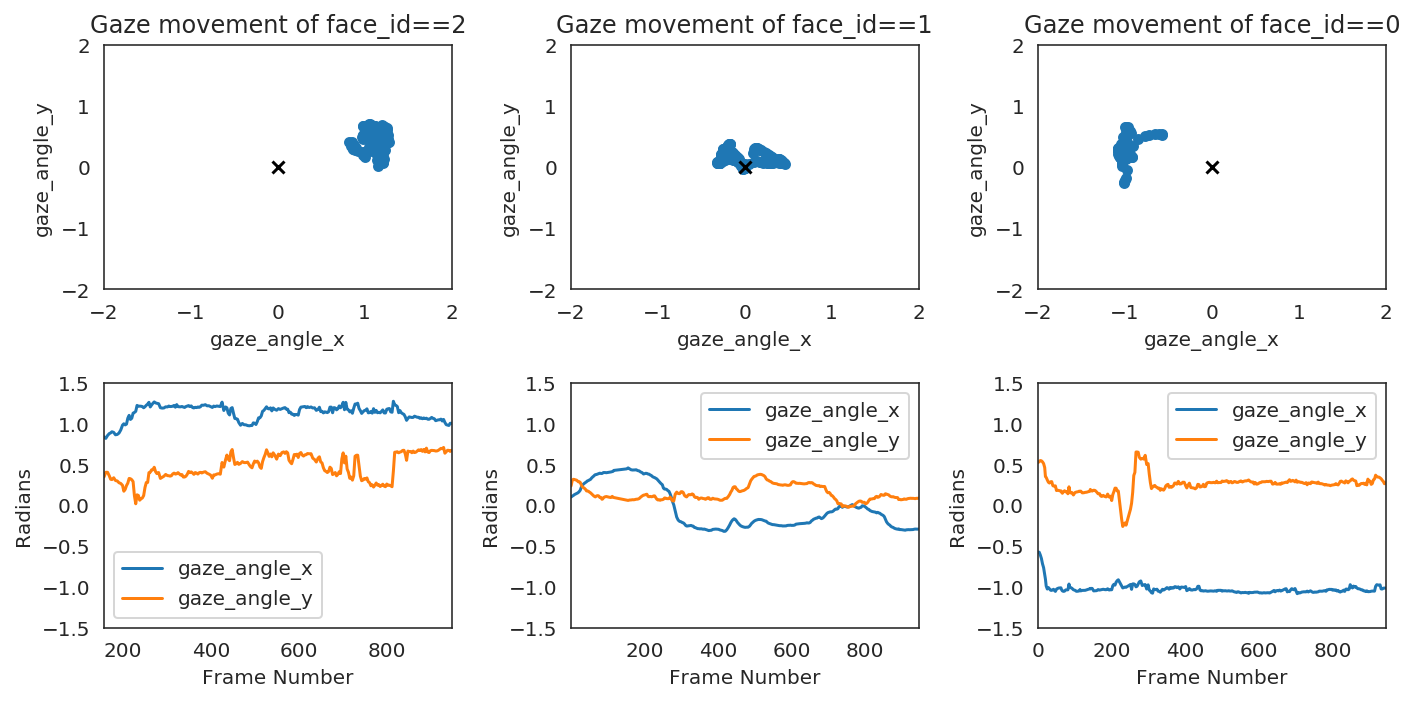

In [ ]:
f,axes = plt.subplots(2,len(df_clean.face_id.unique()), figsize=(10,5))
for faces_ix, face_id in enumerate(df_clean.face_id.unique()[::-1]):
  df_clean.query(f'face_id=={face_id}').plot.scatter(x='gaze_angle_x', y='gaze_angle_y', ax=axes[0][faces_ix])
  axes[0][faces_ix].scatter(0,0, marker='x', color = 'k') # draw origin.
  axes[0][faces_ix].set(xlim=[-2,2], ylim=[-2,2], title=f'Gaze movement of face_id=={face_id}')
  df_clean.query(f'face_id=={face_id}')[['gaze_angle_x', 'gaze_angle_y']].plot(ax=axes[1][faces_ix])
  axes[1][faces_ix].set(ylim=[-1.5,1.5], xlabel='Frame Number', ylabel="Radians")
plt.tight_layout()
plt.show()

# That's it for now. Hope you enjoyed this tutorial.

## Additional resources
*   [OpenFace Github Page](https://github.com/TadasBaltrusaitis/OpenFace)
*   [Medium article on more ways to assess synchrony in time series data](https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9)
*   [Comparison of facial emotion recognition software: OpenFace vs Affectiva vs FACET](https://medium.com/@jinhyuncheong/face-analysis-software-comparison-affectiva-affdex-vs-openface-vs-emotient-facet-5f91a4f12cbb)

*This notebook was prepared by [Jin Hyun Cheong](http://jinhyuncheong.com).*